In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys
import time

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import jax 
import jax.numpy as jnp

In [4]:
import numpyro as npr
from numpyro import sample, plate, deterministic
import numpyro.distributions as dist
from numpyro.infer import Predictive, init_to_value, SVI, Trace_ELBO
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoLaplaceApproximation

/mnt/data/tng/phd/DCM/DCM_ERP_new/.pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
npr.set_platform("cpu")

In [6]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.23
Numpyro version: 0.14.0
Arviz version: 0.18.0


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [9]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler
from Helper.ERPhelper import *
from ModelComparisonFunc import *

## Simulator

In [10]:
rng_key = jax.random.PRNGKey(0)

In [11]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

ns = 9
x_init=np.zeros((ns))

In [12]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

Run the model

In [13]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 124 ms, sys: 3.75 ms, total: 128 ms
Wall time: 125 ms


We use Euler integration (see the ForwardModel for Heun and Rk4 integratores), But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [14]:
@jax.jit
def ERP_JAXOdeintSimulator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [15]:
start_time = time.time()
xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)
print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.09318089485168457


In [16]:
start_time = time.time()
xpy_jax=ERP_JAXOdeintSimulator(x_init, ts, theta_true)
print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.0008957386016845703


## Synthetic Observation

In [17]:
#observation noise
sigma_true = 0.1 

In [18]:
xpy_jax = ERP_JAXOdeintSimulator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [19]:
#downsampling
ds=10

In [20]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [21]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [22]:
data= { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

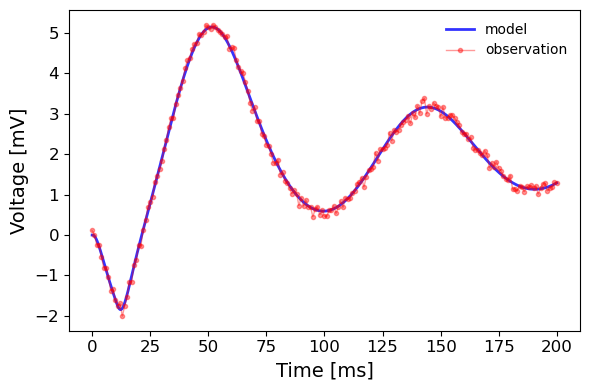

In [23]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);

## Prior

In [24]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)

In [25]:
prior_specs = dict(shape=shape, rate=rate)

In [26]:
n_models = 5
model_labels = ['Full model', r'$g_1 = 0$', r'$g_2 = 0$', r'$g_3 = 0$', r'$g_4 = 0$']
model_nparams = [n_params, n_params-1, n_params-1, n_params-1, n_params-1]

# Laplace approximation

In [28]:
lr = 0.0005
n_iters = 100000
optimizer = Adam(lr)
rng_key = jax.random.PRNGKey(1)

In [29]:
elbos_laplace = []
az_laplace_fits = []

for imodel in range(n_models) :
    
    #define model and guide
    model = make_model(data, prior_specs, model_id=imodel)
    guide = AutoLaplaceApproximation(model)
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

    #RUN SVI 
    time.time()
    svi_res = svi.run(rng_key, n_iters, data, prior_specs, model_id=imodel, stable_update=True)
    print("Model " + str(imodel) + " with SVI Laplace took (sec):" , (time.time() - start_time))
    elbos_laplace.append(-svi_res.losses)
    laplace_post = guide.sample_posterior(rng_key, svi_res.params, sample_shape=(1, 800))
    az_laplace_fits.append(az.from_dict(laplace_post))

100%|██████████| 100000/100000 [00:37<00:00, 2634.47it/s, init loss: 74387.3906, avg. loss [95001-100000]: -477.9912]


Model 0 with SVI Laplace took (sec): 52.85595726966858


100%|██████████| 100000/100000 [00:36<00:00, 2750.59it/s, init loss: 3802571.0000, avg. loss [95001-100000]: -478.5797]


Model 1 with SVI Laplace took (sec): 106.66800165176392


100%|██████████| 100000/100000 [00:35<00:00, 2782.13it/s, init loss: 76555.8984, avg. loss [95001-100000]: 63010.7188]


Model 2 with SVI Laplace took (sec): 158.34480476379395


100%|██████████| 100000/100000 [00:36<00:00, 2709.92it/s, init loss: 61136.0312, avg. loss [95001-100000]: 14475.5332]


Model 3 with SVI Laplace took (sec): 210.01934146881104


100%|██████████| 100000/100000 [00:37<00:00, 2642.94it/s, init loss: 61142.9609, avg. loss [95001-100000]: 14475.5342]


Model 4 with SVI Laplace took (sec): 262.36957478523254


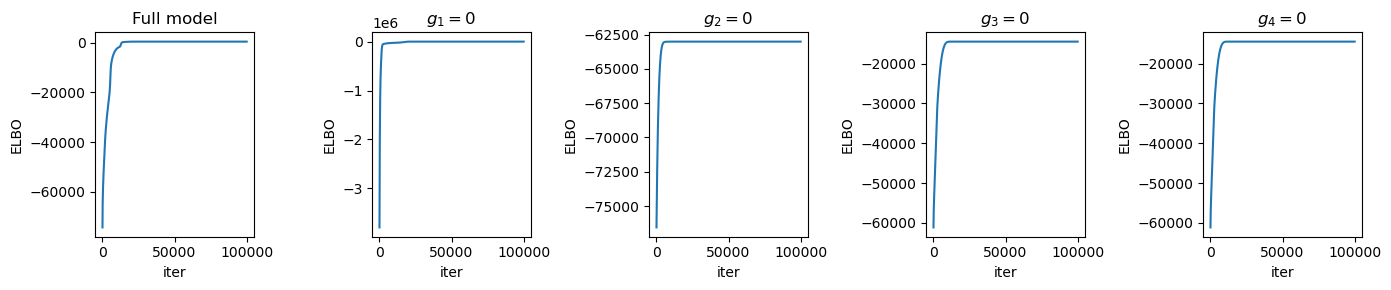

In [30]:
fig, ax = plt.subplots(ncols=5, figsize=(14, 3))
for i in range(n_models) :
    ax[i].plot(elbos_laplace[i])
    ax[i].set(title=model_labels[i], xlabel='iter', ylabel='ELBO')
fig.tight_layout()

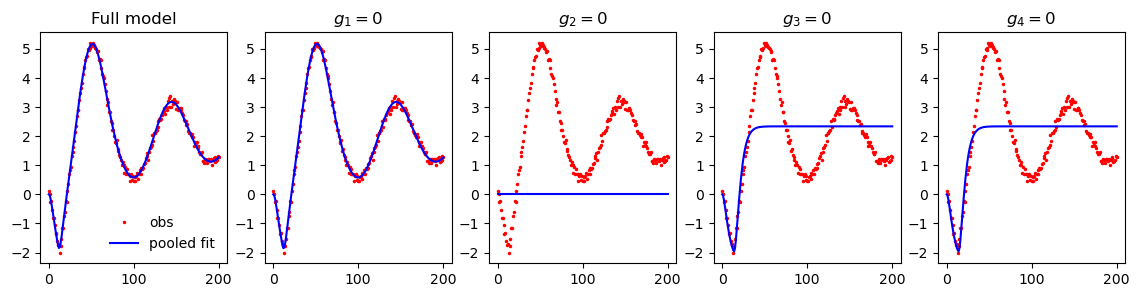

In [31]:
fig, ax = plt.subplots(ncols=n_models, figsize=(14, 3))

for i in range(n_models) :
    ax[i].plot(xpy_obs, 'r.', markersize=3, label='obs')
    ax[i].set_title(model_labels[i])
    xpy_fit = az_laplace_fits[i].posterior['xpy_model']
    ax[i].plot(xpy_fit.mean(axis=(0, 1)), color='b', label='pooled fit')
ax[0].legend(frameon=False)
fig.show()

## Model comparison with free energy

In [32]:
max_elbo_laplace = []
for i in range(5) :
    max_elbo_laplace.append(np.max(elbos_laplace[i]))
max_elbo_laplace = np.array(max_elbo_laplace).flatten()
print(max_elbo_laplace)

[   477.97116    478.56842 -63013.176   -14475.453   -14475.481  ]


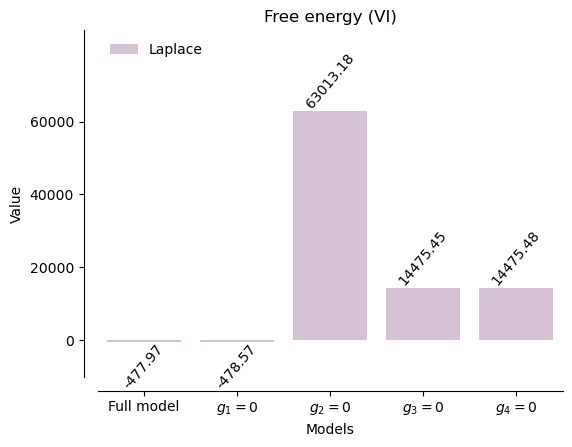

In [33]:
fig, ax = plt.subplots(figsize=(6, 4.5))
sns.barplot(x=model_labels, y=-max_elbo_laplace, color='thistle', label='Laplace', errorbar=None, ax=ax)
for i in range(1) :
    ax.bar_label(ax.containers[i], fmt='%.2f', fontsize=10, rotation=50)
    
ax.set_ylim([-10000, 85000])
ax.set_yticks(range(0, 65000, 20000))   
ax.set_xticks(range(5))
ax.set_xlabel('Models')
ax.set_ylabel('Value')
ax.legend(frameon=False, loc='upper left')
ax.set_title('Free energy (VI)') 
sns.despine(offset=10) ;

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jul 15 2024

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 8.11.0

pandas      : 2.0.3
jax         : 0.4.13
matplotlib  : 3.7.3
numpy       : 1.23.5
clb_nb_utils: 0.1.0.dev0
arviz       : 0.15.1
numpyro     : 0.12.1
seaborn     : 0.12.2

Watermark: 2.4.3

